In [1]:
import deepSI
from deepSI.systems.system import System, System_deriv, System_data
import numpy as np
from matplotlib import pyplot as plt

In [3]:
class Ball_in_box(System_deriv): 
    """docstring for Ball_in_box
    dvxdt = (1/x**2-1/(1-x)**2)/200+ux-self.gamma*vx
    dvydt = (1/y**2-1/(1-y)**2)/200+uy-self.gamma*vy
    """
    def __init__(self, Fmax=0.25, Nresist=0.7):
        self.Fmax = Fmax
        dt = 2*np.pi/20 #20 points in the sin
        self.gamma = Fmax*dt/0.1 # ux*dt/gamma = X=0.1
        super(Ball_in_box, self).__init__(dt=dt,nx=2)
        self.action_space = Box(float(-1),float(1),shape=(2,))

    def reset(self):
        self.x = [0.5,0.5,0,0] #[x,y,vx,vy]
        return self.h(self.x) #return position

    def deriv(self,x,u):
        ux,uy = np.clip(u,-1,1)*self.Fmax
        # print(u)
        x,y,vx,vy = x
        dvxdt = (1/x**2-1/(1-x)**2)/200+ux-self.gamma*vx
        dvydt = (1/y**2-1/(1-y)**2)/200+uy-self.gamma*vy
        return [vx,vy,dvxdt,dvydt]

    def h(self,x):
        return x[0],x[1] #return position

class Ball_in_box_video(Ball_in_box):
    """same as Ball_in_box but with video output
    """
    def __init__(self, Fmax=0.25):
        self.ny_vid, self.nx_vid = 25, 25
        super(Ball_in_box_video, self).__init__(Fmax=Fmax)
        self.observation_space = Box(0.,1.,shape=(self.nx_vid,self.ny_vid)) #overwrite output

    def h(self,x):
        Y = np.linspace(0,1,num=self.ny_vid)
        X = np.linspace(0,1,num=self.nx_vid)
        Y,X = np.meshgrid(Y,X)
        r = 0.22
        A = np.clip((r**2-(X-x[1])**2-(Y-x[0])**2)/r**2,0,1)
        return A #return array

## Generate/Load data

In [4]:
if True:
    np.random.seed(seed=42)
    urand = lambda L: np.random.uniform(low=sys.action_space.low, high=sys.action_space.high, size=(L,2))
    sys = Ball_in_box_video()
    train = System_data(u=urand(30000))
    val = System_data(u=urand(5000))
    test = System_data(u=urand(5000))
    train = sys.apply_experiment(train)
    val = sys.apply_experiment(val)
    test = sys.apply_experiment(test)
    train.save('ball-in-box-data/train')
    val.save('ball-in-box-data/val')
    test.save('ball-in-box-data/test')
else:
    train = deepSI.load_system_data('ball-in-box-data/train.npz')
    val = deepSI.load_system_data('ball-in-box-data/val.npz')
    test = deepSI.load_system_data('ball-in-box-data/test.npz')

In [5]:
np.random.seed(42)
ystd = np.std(train.y.flat)
from copy import deepcopy

def get_noisy(datas,noise):
    datas_noise = [deepcopy(data) for data in datas]
    for data_noise in datas_noise:
        data_noise.y += np.random.normal(scale=ystd*noise,size=data_noise.y.shape)
    return datas_noise

train_5, val_5, test_5  = get_noisy([train,val,test],0.05)
train_20,val_20,test_20 = get_noisy([train,val,test],0.20)
train_50,val_50,test_50 = get_noisy([train,val,test],0.50)
train_100,val_100,test_100 = get_noisy([train,val,test],1.00)

## Fit state-space encoder

In [ ]:
def get_fit_sys_ss(nx=6):
    fit_sys = deepSI.fit_systems.SS_encoder(nx=nx, na=5, nb=5)
    fit_sys.use_norm = False #the norm will not be fitted automatically
    fit_sys.norm.y0 = np.mean(train.y) #fit global values
    fit_sys.norm.ystd = np.std(train.y)
    fit_sys.norm.u0 = np.mean(train.u,axis=0)
    fit_sys.norm.ustd = np.std(train.u,axis=0)
    return fit_sys

if True:
    fit_sys = get_fit_sys_ss()
    fit_sys.fit(train.flatten(),verbose=2, epochs=930, loss_kwargs=dict(nf=50,dilation=5),sim_val=val.flatten())
    fit_sys.save_system('systems/SS-encoder-sys') #prevent accidental overwrite is bad
else:
    fit_sys = deepSI.load_system('systems/SS-encoder-sys')

if True:
    fit_sys_5 = get_fit_sys_ss()
    fit_sys_5.fit(train_5.flatten(),verbose=2, epochs=240, loss_kwargs=dict(nf=50,dilation=5),sim_val=val_5.flatten())
    fit_sys_5.save_system('systems/SS-encoder-sys-5') #prevent accidental overwrite is bad
else:
    fit_sys_5 = deepSI.load_system('systems/SS-encoder-sys-5')
    
if True:
    fit_sys_20 = get_fit_sys_ss()
    fit_sys_20.fit(train_20.flatten(),verbose=2, epochs=240, loss_kwargs=dict(nf=50,dilation=5),sim_val=val_20.flatten())
    fit_sys_20.save_system('systems/SS-encoder-sys-20') #prevent accidental overwrite is bad
else:
    fit_sys_20 = deepSI.load_system('systems/SS-encoder-sys-20')

if True:
    fit_sys_50 = get_fit_sys_ss()
    fit_sys_50.fit(train_50.flatten(),verbose=2, epochs=240, loss_kwargs=dict(nf=50,dilation=5),sim_val=val_50.flatten())
    fit_sys_50.save_system('systems/SS-encoder-sys-50') #prevent accidental overwrite is bad
else:
    fit_sys_50 = deepSI.load_system('systems/SS-encoder-sys-50')

if True:
    fit_sys_100 = get_fit_sys_ss()
    fit_sys_100.fit(train_100.flatten(),verbose=2, epochs=240, loss_kwargs=dict(nf=50,dilation=5),sim_val=val_100.flatten())
    fit_sys_100.save_system('systems/SS-encoder-sys-100') #prevent accidental overwrite is bad
else:
    fit_sys_100 = deepSI.load_system('systems/SS-encoder-sys-100')

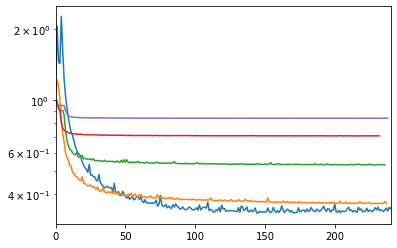

In [24]:
plt.semilogy(fit_sys.Loss_val)
plt.semilogy(fit_sys_5.Loss_val)
plt.semilogy(fit_sys_20.Loss_val)
plt.semilogy(fit_sys_50.Loss_val)
plt.semilogy(fit_sys_100.Loss_val)
plt.xlim(0,240)
plt.show()


In [25]:
test_5_ss = fit_sys_5.apply_experiment(test_5.flatten()).reshape_as(test_5)
test_20_ss = fit_sys_20.apply_experiment(test_20.flatten()).reshape_as(test_20)
test_50_ss = fit_sys_50.apply_experiment(test_50.flatten()).reshape_as(test_50)
test_100_ss = fit_sys_100.apply_experiment(test_100.flatten()).reshape_as(test_100)

## Fit Input-output autoencoder

Reproduction of: Wahlstrom, N., Schon, T.B., and Deisenroth, M.P.
(2015). Learning deep dynamical models from image
pixels. IFAC-PapersOnLine, 48(28), 1059–1064.

In [26]:
def get_IO_sys():
    fit_sys_auto = deepSI.fit_systems.IO_autoencoder(nz=6, na=5, nb=5)
    fit_sys_auto.use_norm = False #the norm will not be fitted automatically
    fit_sys_auto.norm.y0 = np.mean(train.y) #fit global values
    fit_sys_auto.norm.ystd = np.std(train.y)
    fit_sys_auto.norm.u0 = np.mean(train.u,axis=0)
    fit_sys_auto.norm.ustd = np.std(train.u,axis=0)
    return fit_sys_auto

if False:
    fit_sys_auto = get_IO_sys()
    fit_sys_auto.fit(train.flatten(),verbose=2, epochs=15*600, loss_kwargs=dict(),sim_val=val.flatten())
#     fit_sys_auto.save_system('systems/IO-autoencoder-sys') #overwrite is bad
else:
    fit_sys_auto = deepSI.load_system('systems/IO-autoencoder-sys')

if False:
    fit_sys_auto_5 = get_IO_sys()
    fit_sys_auto_5.fit(train_5.flatten(),verbose=2, epochs=1000, loss_kwargs=dict(),sim_val=val_5.flatten())
    fit_sys_auto_5.save_system('systems/IO-autoencoder-sys-5') #overwrite is bad
else:
    fit_sys_auto_5 = deepSI.load_system('systems/IO-autoencoder-sys-5')

if False:
    fit_sys_auto_20 = get_IO_sys()
    fit_sys_auto_20.fit(train_20.flatten(),verbose=2, epochs=1000, loss_kwargs=dict(),sim_val=val_20.flatten())
    fit_sys_auto_20.save_system('systems/IO-autoencoder-sys-20') #overwrite is bad
else:
    fit_sys_auto_20 = deepSI.load_system('systems/IO-autoencoder-sys-20')

if False:
    fit_sys_auto_50 = get_IO_sys()
    fit_sys_auto_50.fit(train_50.flatten(),verbose=2, epochs=1000, loss_kwargs=dict(),sim_val=val_50.flatten())
    fit_sys_auto_50.save_system('systems/IO-autoencoder-sys-50') #overwrite is bad
else:
    fit_sys_auto_50 = deepSI.load_system('systems/IO-autoencoder-sys-50')

if False:
    fit_sys_auto_100 = get_IO_sys()
    fit_sys_auto_100.fit(train_100.flatten(),verbose=2, epochs=1000, loss_kwargs=dict(),sim_val=val_100.flatten())
    fit_sys_auto_100.save_system('systems/IO-autoencoder-sys-100') #overwrite is bad
else:
    fit_sys_auto_100 = deepSI.load_system('systems/IO-autoencoder-sys-100')

In [27]:
test_SS_encoder, test_IO_auto = fit_sys.apply_experiment(test.flatten()).reshape_as(test), fit_sys_auto.apply_experiment(test.flatten()).reshape_as(test)
train_SS_encoder, train_IO_auto = fit_sys.apply_experiment(train.flatten()).reshape_as(train), fit_sys_auto.apply_experiment(train.flatten()).reshape_as(train)

In [28]:
test_5_auto = fit_sys_auto_5.apply_experiment(test_5.flatten()).reshape_as(test_5)
test_20_auto = fit_sys_auto_20.apply_experiment(test_20.flatten()).reshape_as(test_20)
test_50_auto = fit_sys_auto_50.apply_experiment(test_50.flatten()).reshape_as(test_50)
test_100_auto = fit_sys_auto_100.apply_experiment(test_100.flatten()).reshape_as(test_100)

## Main RMS/NRSM Result

 ########## Train #############
	 IO auto encoder RMS = 0.01242, NRMS = 6.08%
	 SS      encoder RMS = 0.01164, NRMS = 5.69%

 ########## Test ############
	 IO auto encoder     RMS = 0.01503, NRMS = 7.35%
	 SS      encoder     RMS = 0.01343, NRMS = 6.57%
	 IO auto encoder 5   RMS = 0.01557, NRMS = 7.61%
	 SS      encoder 5   RMS = 0.01445, NRMS = 7.07%
	 IO auto encoder 20  RMS = 0.0175, NRMS = 8.56%
	 SS      encoder 20  RMS = 0.01544, NRMS = 7.55%
	 IO auto encoder 50  RMS = 0.02494, NRMS = 12.20%
	 SS      encoder 50  RMS = 0.01616, NRMS = 7.90%
	 IO auto encoder 100 RMS = 0.0287, NRMS = 14.04%
	 SS      encoder 100 RMS = 0.01922, NRMS = 9.40%


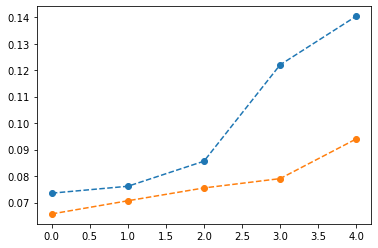

In [29]:
print(' ########## Train #############')
print(f'\t IO auto encoder RMS = {train_IO_auto.RMS(train):.4}, NRMS = {train_IO_auto.RMS(train)/np.std(test.y):.2%}')
print(f'\t SS      encoder RMS = {train_SS_encoder.RMS(train):.4}, NRMS = {train_SS_encoder.RMS(train)/np.std(test.y):.2%}')

print('\n ########## Test ############')
print(f'\t IO auto encoder     RMS = {test_IO_auto.RMS(test):4.04}, NRMS = {test_IO_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder     RMS = {test_SS_encoder.RMS(test):4.04}, NRMS = {test_SS_encoder.RMS(test)/np.std(test.y):.2%}')
print(f'\t IO auto encoder 5   RMS = {test_5_auto.RMS(test):4.4}, NRMS = {test_5_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder 5   RMS = {test_5_ss.RMS(test):4.4}, NRMS = {test_5_ss.RMS(test)/np.std(test.y):.2%}')
print(f'\t IO auto encoder 20  RMS = {test_20_auto.RMS(test):4.4}, NRMS = {test_20_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder 20  RMS = {test_20_ss.RMS(test):4.4}, NRMS = {test_20_ss.RMS(test)/np.std(test.y):.2%}')
print(f'\t IO auto encoder 50  RMS = {test_50_auto.RMS(test):4.4}, NRMS = {test_50_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder 50  RMS = {test_50_ss.RMS(test):4.4}, NRMS = {test_50_ss.RMS(test)/np.std(test.y):.2%}')
print(f'\t IO auto encoder 100 RMS = {test_100_auto.RMS(test):4.4}, NRMS = {test_100_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder 100 RMS = {test_100_ss.RMS(test):4.4}, NRMS = {test_100_ss.RMS(test)/np.std(test.y):.2%}')
P = [test_IO_auto.RMS(test)/np.std(test.y),test_SS_encoder.RMS(test)/np.std(test.y),test_5_auto.RMS(test)/np.std(test.y),test_5_ss.RMS(test)/np.std(test.y),test_20_auto.RMS(test)/np.std(test.y),test_20_ss.RMS(test)/np.std(test.y),test_50_auto.RMS(test)/np.std(test.y),test_50_ss.RMS(test)/np.std(test.y),test_100_auto.RMS(test)/np.std(test.y),test_100_ss.RMS(test)/np.std(test.y)]
IO_performs = P[::2]
SS_performs = P[1::2]
plt.plot(IO_performs,'o--')
plt.plot(SS_performs,'o--')
plt.show()

## Validation simulation error during training

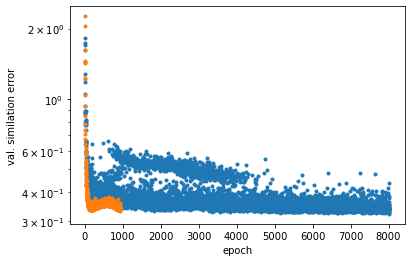

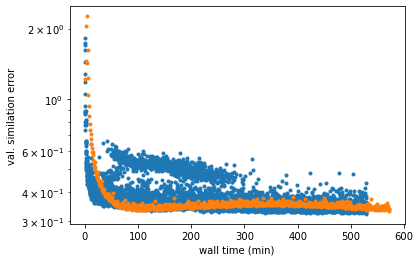

In [30]:
plt.semilogy(fit_sys_auto.Loss_val,'.')
plt.semilogy(np.array(fit_sys.Loss_val),'.')
plt.xlabel('epoch')
plt.ylabel('val. similation error')
plt.show()
plt.semilogy(fit_sys_auto.time/60,fit_sys_auto.Loss_val,'.')
plt.semilogy(np.array(fit_sys.time)/60,np.array(fit_sys.Loss_val),'.')
plt.xlabel('wall time (min)')
plt.ylabel('val. similation error')
plt.show()

## Figure 3: Time compare

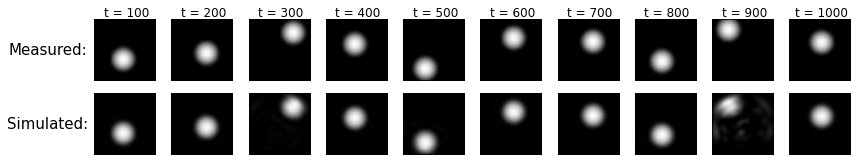

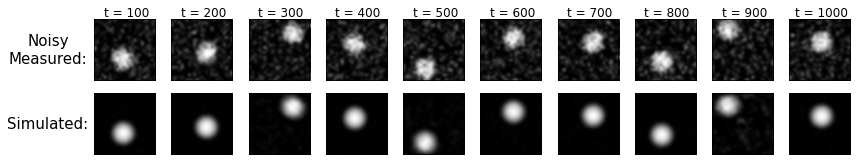

In [45]:
def make_figure(test,test_sim,name,Measured='Measured'):
    Xmax,Ymax = test.y[0].shape
    Y = test.y[100]
    def ball_show(Y,t,text=True):
        Y = np.clip(Y,0,1)
        plt.imshow(Y,cmap='gray',interpolation='bicubic',origin='lower')
        plt.plot(np.array([0,Ymax,Ymax,0,0])-0.5,np.array([0,0,Xmax,Xmax,0])-0.5,'k')
        if text: plt.text(Ymax/2,Xmax*1.075,'t = {}'.format(t),horizontalalignment='center',verticalalignment='center',fontdict=dict(size=12))
        plt.axis('off')
        #add other things


    offset = 26 #show extrapolation in 900
    tlist = list(range(100,1001,100))
    plt.figure(figsize=(15,2.5))
    plt.subplot(2,len(tlist)+1,1)
    plt.text(0.5,0.5,f'{Measured}:',horizontalalignment='center',verticalalignment='center',fontdict=dict(size=15))
    plt.axis('off')
    plt.subplot(2,len(tlist)+1,len(tlist)+1+1)
    plt.text(0.5,0.5,'Simulated:',horizontalalignment='center',verticalalignment='center',fontdict=dict(size=15))
    plt.axis('off')

    for k,t in enumerate(tlist):
        plt.subplot(2,len(tlist)+1,1+k+1)
        ball_show(test.y[t+offset],t)
        plt.subplot(2,len(tlist)+1,(1+len(tlist))+1+k+1)
        ball_show(test_sim.y[t+offset],t,text=False)
    # plt.tight_layout() #does not work
    plt.savefig(f'./figures/{name}.jpg',dpi=200)
    img0 = plt.imread(f'./figures/{name}.jpg')

    #manual tight layout
    img = np.mean(img0,axis=2)
    xdiffs = np.arange(img.shape[1])[np.mean(img,axis=0)<255]
    ydiffs = np.arange(img.shape[0])[np.mean(img,axis=1)<255]
    xmin,xmax = np.min(xdiffs), np.max(xdiffs)
    ymin,ymax = np.min(ydiffs), np.max(ydiffs)
    plt.imsave(f'./figures/{name}.jpg',img0[ymin-1:ymax+1,xmin-1:xmax+1])
    plt.show()
make_figure(test,test_SS_encoder,'strip')
make_figure(test_100,test_100_ss,'strip-100-noise',Measured='Noisy\nMeasured')

## Figure 4: Error in time

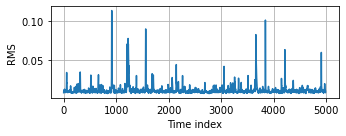

In [38]:
diff = (test_SS_encoder-test)
plt.figure(figsize=(5,2))
plt.plot(np.mean(diff.y[10:]**2,axis=(1,2))**0.5) 
plt.ylabel('RMS')
plt.xlabel('Time index')
plt.tight_layout()
plt.grid()
plt.savefig('./figures/time-square-error.pdf')
plt.show()

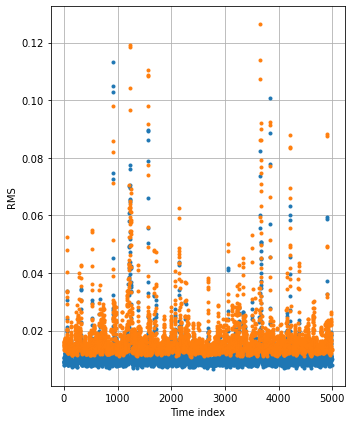

In [41]:
diff = (test_SS_encoder-test)
diff2 = (test_100_ss-test)
plt.figure(figsize=(5,6))
plt.plot(np.mean(diff.y[10:]**2,axis=(1,2))**0.5,'.') 
plt.plot(np.mean(diff2.y[10:]**2,axis=(1,2))**0.5,'.') 
plt.ylabel('RMS')
plt.xlabel('Time index')
plt.tight_layout()
plt.grid()
plt.savefig('./figures/time-square-error-noise.pdf')
plt.show()

## Figure 5: n-step error

The error one expect to find after taking n steps.

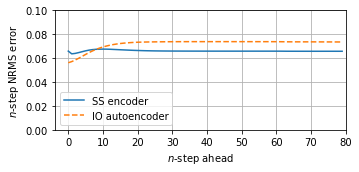

In [82]:
plt.figure(figsize=(5,2.5))
plt.plot(fit_sys.n_step_error(test.flatten(),RMS=False,nf=80),label='SS encoder') #uses the norm
plt.plot(fit_sys_auto.n_step_error(test.flatten(),RMS=False,nf=80),'--',label='IO autoencoder') #uses the norm
# plt.plot(fit_sys.n_step_error(train[:5000].flatten(),RMS=False,nf=80),label='train') #uses the norm
plt.ylim(0,0.1)
plt.ylabel('$n$-step NRMS error')
plt.xlabel('$n$-step ahead')
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig('./figures/n-step-error.pdf')
plt.xlim(None,80)
plt.show()


## Video's

In [11]:
# test_predict.reshape_as(test).to_video(file_name='test-predict-ball-box-2')
# test.to_video(file_name='test-ball-box-2')
#requires cv2
limit = 1500
test[:limit].to_video('videos/test-measured')
test_SS_encoder[:limit].to_video('videos/test-SS-encoder')
test_IO_auto[:limit].to_video('videos/test-IO-autoencoder')

#combined videos
System_data(y=np.concatenate((test.y,test_SS_encoder.y),axis=2))[:limit].to_video(file_name='videos/test-sim-measured-and-SS-encoder')
System_data(y=np.concatenate((test.y,test_SS_encoder.y,test_IO_auto.y),axis=2))[:limit].to_video(file_name='videos/test-sim-measured-SS-encoder-and-IO-auto-encoder')

In [41]:
limit = 1500
System_data(y=np.concatenate((test_5.y,test_5_ss.y),axis=2))[:limit].to_video(file_name='videos/noise5-ss')
System_data(y=np.concatenate((test_20.y,test_20_ss.y),axis=2))[:limit].to_video(file_name='videos/noise20-ss')
System_data(y=np.concatenate((test_50.y,test_50_ss.y),axis=2))[:limit].to_video(file_name='videos/noise50-ss')
System_data(y=np.concatenate((test_100.y,test_50_ss.y),axis=2))[:limit].to_video(file_name='videos/noise100-ss')
# System_data(y=np.concatenate((test_5.y,test_5_ss.y),axis=2))[:limit].to_video(file_name='videos/noise5-ss')

## Reproduceability @ nx=4

In [6]:

if True:
    fit_sys_nx4_1 = get_fit_sys_ss(nx=4)
    fit_sys_nx4_1.fit(train.flatten(),verbose=2, epochs=350, loss_kwargs=dict(nf=50),sim_val=val.flatten())
    fit_sys_nx4_1.save_system('systems/SS-encoder-sys-nx4-1') #prevent accidental overwrite is bad
else:
    fit_sys_nx4_1 = deepSI.load_system('systems/SS-encoder-sys-nx4-1')

if True:
    fit_sys_nx4_2 = get_fit_sys_ss(nx=4)
    fit_sys_nx4_2.fit(train.flatten(),verbose=2, epochs=350, loss_kwargs=dict(nf=50),sim_val=val.flatten())
    fit_sys_nx4_2.save_system('systems/SS-encoder-sys-nx4-2') #prevent accidental overwrite is bad
else:
    fit_sys_nx4_2 = deepSI.load_system('systems/SS-encoder-sys-nx4-2')

if True:
    fit_sys_nx4_3 = get_fit_sys_ss(nx=4)
    fit_sys_nx4_3.fit(train.flatten(),verbose=2, epochs=350, loss_kwargs=dict(nf=50),sim_val=val.flatten())
    fit_sys_nx4_3.save_system('systems/SS-encoder-sys-nx4-3') #prevent accidental overwrite is bad
else:
    fit_sys_nx4_3 = deepSI.load_system('systems/SS-encoder-sys-nx4-3')
    
if True:
    fit_sys_nx6_1 = get_fit_sys_ss(nx=6)
    fit_sys_nx6_1.fit(train.flatten(),verbose=2, epochs=350, loss_kwargs=dict(nf=50),sim_val=val.flatten())
    fit_sys_nx6_1.save_system('systems/SS-encoder-sys-nx6-1') #prevent accidental overwrite is bad
else:
    fit_sys_nx6_1 = deepSI.load_system('systems/SS-encoder-sys-nx6-1')


########## new best ########### 5.729397858484154
N_training_samples=29946, batch_size=256, N_batch_updates_per_epoch=116


########## new best ########### 1.0821014073088
Epoch:    1 Training loss:   0.811 Validation loss =  1.082, time Loss: 41.3%, back: 48.1%, val: 5.3%
Epoch:    2 Training loss:   0.689 Validation loss =  1.611, time Loss: 41.1%, back: 48.1%, val: 5.5%
Epoch:    3 Training loss:  0.5247 Validation loss =  1.242, time Loss: 40.9%, back: 48.0%, val: 5.8%
Epoch:    4 Training loss:  0.4757 Validation loss =  1.137, time Loss: 40.7%, back: 47.5%, val: 6.1%
Epoch:    5 Training loss:  0.4648 Validation loss =  1.151, time Loss: 40.6%, back: 47.2%, val: 6.4%
Epoch:    6 Training loss:  0.4048 Validation loss =  1.477, time Loss: 40.5%, back: 47.0%, val: 6.6%
Epoch:    7 Training loss:  0.2141 Validation loss =   1.12, time Loss: 40.6%, back: 46.6%, val: 6.7%
########## new best ########### 0.9202920583556294
Epoch:    8 Training loss:  0.1379 Validation loss = 0.9203, time Loss: 40.5%, back: 46.4%, val: 6.8%
########## new best ########### 0.8073126747120678
Epoch:    9 Training loss:  0.1011

Epoch:   63 Training loss: 0.009871 Validation loss = 0.3838, time Loss: 40.1%, back: 46.3%, val: 7.0%
########## new best ########### 0.3785523617683376
Epoch:   64 Training loss: 0.008677 Validation loss = 0.3786, time Loss: 40.1%, back: 46.3%, val: 7.0%
Epoch:   65 Training loss: 0.009776 Validation loss = 0.3901, time Loss: 40.2%, back: 46.3%, val: 7.0%
########## new best ########### 0.3766747889899088
Epoch:   66 Training loss: 0.008174 Validation loss = 0.3767, time Loss: 40.2%, back: 46.3%, val: 7.0%
########## new best ########### 0.3754530998174527
Epoch:   67 Training loss: 0.008914 Validation loss = 0.3755, time Loss: 40.2%, back: 46.3%, val: 7.0%
Epoch:   68 Training loss: 0.008637 Validation loss = 0.3761, time Loss: 40.2%, back: 46.3%, val: 7.0%
Epoch:   69 Training loss: 0.008343 Validation loss = 0.3786, time Loss: 40.2%, back: 46.3%, val: 7.0%
########## new best ########### 0.36859126339032794
Epoch:   70 Training loss: 0.009236 Validation loss = 0.3686, time Loss: 4

########## new best ########### 0.34433130026542463
Epoch:  135 Training loss: 0.006297 Validation loss = 0.3443, time Loss: 39.9%, back: 46.6%, val: 7.0%
Epoch:  136 Training loss: 0.006223 Validation loss = 0.3489, time Loss: 39.9%, back: 46.6%, val: 7.0%
Epoch:  137 Training loss: 0.006401 Validation loss = 0.3538, time Loss: 39.9%, back: 46.6%, val: 7.0%
Epoch:  138 Training loss: 0.005924 Validation loss = 0.3447, time Loss: 39.9%, back: 46.6%, val: 7.0%
Epoch:  139 Training loss: 0.006163 Validation loss = 0.3584, time Loss: 39.9%, back: 46.6%, val: 7.0%
Epoch:  140 Training loss: 0.006234 Validation loss = 0.3498, time Loss: 39.9%, back: 46.6%, val: 7.0%
Epoch:  141 Training loss: 0.006281 Validation loss = 0.3507, time Loss: 39.9%, back: 46.6%, val: 7.0%
Epoch:  142 Training loss: 0.005795 Validation loss =   0.35, time Loss: 39.9%, back: 46.7%, val: 7.0%
Epoch:  143 Training loss: 0.006327 Validation loss = 0.3468, time Loss: 39.9%, back: 46.7%, val: 7.0%
Epoch:  144 Training 

Epoch:  213 Training loss: 0.004673 Validation loss = 0.3518, time Loss: 39.8%, back: 46.7%, val: 6.9%
Epoch:  214 Training loss: 0.005127 Validation loss = 0.3478, time Loss: 39.8%, back: 46.7%, val: 6.9%
Epoch:  215 Training loss: 0.004978 Validation loss = 0.3476, time Loss: 39.8%, back: 46.7%, val: 6.9%
Epoch:  216 Training loss: 0.005107 Validation loss = 0.3516, time Loss: 39.8%, back: 46.7%, val: 6.9%
Epoch:  217 Training loss: 0.005079 Validation loss = 0.3458, time Loss: 39.8%, back: 46.7%, val: 6.9%
Epoch:  218 Training loss: 0.005262 Validation loss = 0.3549, time Loss: 39.8%, back: 46.7%, val: 6.9%
Epoch:  219 Training loss: 0.00478 Validation loss =  0.346, time Loss: 39.8%, back: 46.7%, val: 6.9%
Epoch:  220 Training loss: 0.004943 Validation loss = 0.3507, time Loss: 39.8%, back: 46.7%, val: 6.9%
Epoch:  221 Training loss: 0.004882 Validation loss = 0.3468, time Loss: 39.8%, back: 46.7%, val: 6.9%
Epoch:  222 Training loss:   0.005 Validation loss = 0.3433, time Loss: 39

Epoch:  293 Training loss: 0.004326 Validation loss = 0.3505, time Loss: 39.9%, back: 46.7%, val: 6.9%
Epoch:  294 Training loss: 0.004621 Validation loss = 0.3496, time Loss: 39.9%, back: 46.7%, val: 6.9%
Epoch:  295 Training loss: 0.004338 Validation loss = 0.3498, time Loss: 39.9%, back: 46.7%, val: 6.9%
Epoch:  296 Training loss: 0.004468 Validation loss = 0.3504, time Loss: 39.9%, back: 46.7%, val: 6.9%
Epoch:  297 Training loss: 0.004495 Validation loss = 0.3494, time Loss: 39.9%, back: 46.7%, val: 6.9%
Epoch:  298 Training loss:  0.0043 Validation loss = 0.3521, time Loss: 39.9%, back: 46.7%, val: 6.9%
Epoch:  299 Training loss: 0.004853 Validation loss = 0.3551, time Loss: 39.9%, back: 46.7%, val: 6.9%
Epoch:  300 Training loss: 0.004825 Validation loss = 0.3489, time Loss: 39.9%, back: 46.7%, val: 6.9%
Epoch:  301 Training loss: 0.004191 Validation loss = 0.3559, time Loss: 39.9%, back: 46.7%, val: 6.9%
Epoch:  302 Training loss: 0.004387 Validation loss = 0.3498, time Loss: 3

########## new best ########### 1.0572991625919883
Epoch:    1 Training loss:  0.8117 Validation loss =  1.057, time Loss: 41.3%, back: 47.8%, val: 5.4%
Epoch:    2 Training loss:  0.7341 Validation loss =  1.749, time Loss: 41.1%, back: 48.2%, val: 5.4%
Epoch:    3 Training loss:  0.5783 Validation loss =  1.306, time Loss: 41.0%, back: 48.4%, val: 5.4%
Epoch:    4 Training loss:  0.4956 Validation loss =  1.164, time Loss: 41.1%, back: 48.3%, val: 5.4%
Epoch:    5 Training loss:  0.4754 Validation loss =  1.116, time Loss: 41.1%, back: 48.3%, val: 5.4%
Epoch:    6 Training loss:  0.4672 Validation loss =  1.107, time Loss: 41.1%, back: 48.3%, val: 5.4%
Epoch:    7 Training loss:  0.4611 Validation loss =  1.251, time Loss: 41.1%, back: 48.3%, val: 5.4%
Epoch:    8 Training loss:  0.3579 Validation loss =  1.324, time Loss: 41.2%, back: 48.3%, val: 5.4%
Epoch:    9 Training loss:  0.2548 Validation loss =  1.206, time Loss: 41.0%, back: 48.3%, val: 5.5%
########## new best ###########

Epoch:   66 Training loss:  0.0117 Validation loss = 0.4033, time Loss: 41.2%, back: 47.8%, val: 5.6%
Epoch:   67 Training loss: 0.01089 Validation loss = 0.3997, time Loss: 41.2%, back: 47.8%, val: 5.6%
Epoch:   68 Training loss: 0.01112 Validation loss = 0.3961, time Loss: 41.2%, back: 47.8%, val: 5.6%
Epoch:   69 Training loss: 0.01085 Validation loss = 0.4009, time Loss: 41.2%, back: 47.8%, val: 5.6%
########## new best ########### 0.38990908283630654
Epoch:   70 Training loss: 0.01153 Validation loss = 0.3899, time Loss: 41.2%, back: 47.8%, val: 5.6%
########## new best ########### 0.38773428418753303
Epoch:   71 Training loss: 0.01062 Validation loss = 0.3877, time Loss: 41.2%, back: 47.8%, val: 5.6%
Epoch:   72 Training loss: 0.01145 Validation loss = 0.4005, time Loss: 41.2%, back: 47.8%, val: 5.6%
Epoch:   73 Training loss: 0.009694 Validation loss = 0.3892, time Loss: 41.3%, back: 47.7%, val: 5.6%
Epoch:   74 Training loss:   0.011 Validation loss = 0.3905, time Loss: 41.3%, 

Epoch:  139 Training loss: 0.006225 Validation loss = 0.3637, time Loss: 41.1%, back: 47.4%, val: 5.9%
Epoch:  140 Training loss: 0.00677 Validation loss = 0.3685, time Loss: 41.1%, back: 47.4%, val: 5.9%
Epoch:  141 Training loss: 0.006562 Validation loss = 0.3681, time Loss: 41.1%, back: 47.4%, val: 5.9%
Epoch:  142 Training loss: 0.006484 Validation loss =  0.366, time Loss: 41.0%, back: 47.4%, val: 5.9%
Epoch:  143 Training loss: 0.007098 Validation loss = 0.3751, time Loss: 41.0%, back: 47.4%, val: 5.9%
Epoch:  144 Training loss: 0.006712 Validation loss = 0.3765, time Loss: 41.0%, back: 47.4%, val: 5.9%
Epoch:  145 Training loss: 0.00659 Validation loss = 0.3635, time Loss: 41.0%, back: 47.4%, val: 5.9%
Epoch:  146 Training loss: 0.008012 Validation loss =  0.364, time Loss: 41.0%, back: 47.4%, val: 5.9%
########## new best ########### 0.3615415956060847
Epoch:  147 Training loss: 0.006158 Validation loss = 0.3615, time Loss: 41.0%, back: 47.4%, val: 5.9%
Epoch:  148 Training los

Epoch:  217 Training loss: 0.005733 Validation loss = 0.3706, time Loss: 40.7%, back: 47.2%, val: 6.2%
Epoch:  218 Training loss: 0.005367 Validation loss = 0.3697, time Loss: 40.7%, back: 47.2%, val: 6.2%
Epoch:  219 Training loss: 0.005274 Validation loss = 0.3581, time Loss: 40.7%, back: 47.2%, val: 6.2%
Epoch:  220 Training loss: 0.005321 Validation loss = 0.3622, time Loss: 40.7%, back: 47.2%, val: 6.2%
Epoch:  221 Training loss: 0.005544 Validation loss = 0.3614, time Loss: 40.7%, back: 47.2%, val: 6.2%
Epoch:  222 Training loss: 0.005257 Validation loss = 0.3629, time Loss: 40.7%, back: 47.2%, val: 6.2%
Epoch:  223 Training loss: 0.006192 Validation loss =   0.36, time Loss: 40.7%, back: 47.2%, val: 6.2%
Epoch:  224 Training loss: 0.004851 Validation loss = 0.3585, time Loss: 40.7%, back: 47.2%, val: 6.2%
Epoch:  225 Training loss: 0.005408 Validation loss = 0.3686, time Loss: 40.7%, back: 47.2%, val: 6.2%
Epoch:  226 Training loss: 0.005665 Validation loss = 0.3623, time Loss: 

########## new best ########### 0.35380904348996195
Epoch:  296 Training loss: 0.004955 Validation loss = 0.3538, time Loss: 40.5%, back: 47.1%, val: 6.3%
Epoch:  297 Training loss: 0.005099 Validation loss = 0.3629, time Loss: 40.5%, back: 47.1%, val: 6.3%
Epoch:  298 Training loss: 0.004433 Validation loss = 0.3628, time Loss: 40.5%, back: 47.1%, val: 6.3%
Epoch:  299 Training loss: 0.00484 Validation loss = 0.3557, time Loss: 40.5%, back: 47.1%, val: 6.3%
########## new best ########### 0.3535668929954616
Epoch:  300 Training loss: 0.004689 Validation loss = 0.3536, time Loss: 40.5%, back: 47.1%, val: 6.3%
Epoch:  301 Training loss: 0.004622 Validation loss = 0.3558, time Loss: 40.5%, back: 47.1%, val: 6.3%
Epoch:  302 Training loss: 0.005033 Validation loss = 0.3582, time Loss: 40.5%, back: 47.1%, val: 6.3%
Epoch:  303 Training loss: 0.004578 Validation loss = 0.3667, time Loss: 40.5%, back: 47.1%, val: 6.4%
Epoch:  304 Training loss: 0.004793 Validation loss = 0.3602, time Loss: 4

########## new best ########### 1.0560037782843446
Epoch:    1 Training loss:  0.8101 Validation loss =  1.056, time Loss: 41.6%, back: 47.7%, val: 5.2%
Epoch:    2 Training loss:  0.6759 Validation loss =   1.59, time Loss: 41.4%, back: 48.1%, val: 5.3%
Epoch:    3 Training loss:  0.5165 Validation loss =  1.196, time Loss: 41.3%, back: 48.2%, val: 5.3%
Epoch:    4 Training loss:  0.4766 Validation loss =  1.092, time Loss: 41.4%, back: 48.2%, val: 5.3%
########## new best ########### 1.039783517292688
Epoch:    5 Training loss:  0.4668 Validation loss =   1.04, time Loss: 41.1%, back: 48.6%, val: 5.3%
########## new best ########### 1.0190739165415337
Epoch:    6 Training loss:  0.4626 Validation loss =  1.019, time Loss: 41.1%, back: 48.5%, val: 5.3%
########## new best ########### 0.9995388757781727
Epoch:    7 Training loss:  0.4603 Validation loss = 0.9995, time Loss: 41.2%, back: 48.4%, val: 5.3%
########## new best ########### 0.9922373830823903
Epoch:    8 Training loss:  0.45

Epoch:   59 Training loss: 0.01141 Validation loss = 0.3881, time Loss: 41.6%, back: 47.6%, val: 5.5%
Epoch:   60 Training loss: 0.01107 Validation loss = 0.3898, time Loss: 41.6%, back: 47.6%, val: 5.5%
Epoch:   61 Training loss: 0.01082 Validation loss = 0.3882, time Loss: 41.6%, back: 47.6%, val: 5.5%
########## new best ########### 0.38637244311914276
Epoch:   62 Training loss: 0.01126 Validation loss = 0.3864, time Loss: 41.6%, back: 47.6%, val: 5.5%
Epoch:   63 Training loss: 0.01115 Validation loss = 0.3989, time Loss: 41.6%, back: 47.6%, val: 5.5%
Epoch:   64 Training loss: 0.01049 Validation loss = 0.3904, time Loss: 41.6%, back: 47.6%, val: 5.5%
Epoch:   65 Training loss: 0.01087 Validation loss = 0.3925, time Loss: 41.6%, back: 47.6%, val: 5.5%
Epoch:   66 Training loss: 0.01016 Validation loss = 0.3871, time Loss: 41.6%, back: 47.6%, val: 5.5%
Epoch:   67 Training loss: 0.01074 Validation loss = 0.3919, time Loss: 41.6%, back: 47.6%, val: 5.5%
Epoch:   68 Training loss:  0.

Epoch:  132 Training loss: 0.006389 Validation loss = 0.3714, time Loss: 41.3%, back: 47.2%, val: 5.7%
Epoch:  133 Training loss: 0.007465 Validation loss = 0.3701, time Loss: 41.3%, back: 47.2%, val: 5.7%
########## new best ########### 0.3680423127291739
Epoch:  134 Training loss: 0.006662 Validation loss =  0.368, time Loss: 41.3%, back: 47.2%, val: 5.7%
########## new best ########### 0.3680028028520242
Epoch:  135 Training loss: 0.006233 Validation loss =  0.368, time Loss: 41.3%, back: 47.2%, val: 5.8%
Epoch:  136 Training loss: 0.007246 Validation loss = 0.3709, time Loss: 41.3%, back: 47.2%, val: 5.8%
Epoch:  137 Training loss:  0.0065 Validation loss =  0.369, time Loss: 41.3%, back: 47.2%, val: 5.8%
Epoch:  138 Training loss: 0.007174 Validation loss = 0.3732, time Loss: 41.3%, back: 47.2%, val: 5.8%
Epoch:  139 Training loss: 0.006121 Validation loss = 0.3695, time Loss: 41.3%, back: 47.2%, val: 5.8%
########## new best ########### 0.36529326290565056
Epoch:  140 Training lo

Epoch:  206 Training loss: 0.005314 Validation loss = 0.3534, time Loss: 41.1%, back: 46.9%, val: 6.0%
Epoch:  207 Training loss: 0.005444 Validation loss = 0.3518, time Loss: 41.1%, back: 46.9%, val: 6.0%
Epoch:  208 Training loss: 0.005586 Validation loss = 0.3548, time Loss: 41.1%, back: 46.9%, val: 6.0%
Epoch:  209 Training loss: 0.005294 Validation loss = 0.3508, time Loss: 41.1%, back: 46.9%, val: 6.0%
Epoch:  210 Training loss: 0.005514 Validation loss = 0.3519, time Loss: 41.1%, back: 46.9%, val: 6.0%
Epoch:  211 Training loss: 0.005517 Validation loss = 0.3522, time Loss: 41.1%, back: 46.9%, val: 6.0%
Epoch:  212 Training loss: 0.005486 Validation loss = 0.3561, time Loss: 41.1%, back: 46.9%, val: 6.0%
Epoch:  213 Training loss: 0.005209 Validation loss = 0.3533, time Loss: 41.0%, back: 46.9%, val: 6.0%
Epoch:  214 Training loss: 0.005516 Validation loss = 0.3538, time Loss: 41.0%, back: 46.9%, val: 6.0%
########## new best ########### 0.3492569385078685
Epoch:  215 Training l

Epoch:  282 Training loss: 0.004694 Validation loss = 0.3408, time Loss: 40.9%, back: 46.8%, val: 6.1%
Epoch:  283 Training loss: 0.004596 Validation loss = 0.3412, time Loss: 40.9%, back: 46.8%, val: 6.1%
Epoch:  284 Training loss: 0.005031 Validation loss = 0.3459, time Loss: 40.9%, back: 46.8%, val: 6.1%
Epoch:  285 Training loss: 0.004832 Validation loss = 0.3442, time Loss: 40.9%, back: 46.8%, val: 6.1%
Epoch:  286 Training loss: 0.004881 Validation loss = 0.3449, time Loss: 40.9%, back: 46.8%, val: 6.1%
Epoch:  287 Training loss: 0.004482 Validation loss = 0.3421, time Loss: 40.9%, back: 46.8%, val: 6.1%
Epoch:  288 Training loss: 0.004851 Validation loss = 0.3436, time Loss: 40.9%, back: 46.8%, val: 6.1%
Epoch:  289 Training loss: 0.004533 Validation loss = 0.3405, time Loss: 40.9%, back: 46.8%, val: 6.1%
Epoch:  290 Training loss: 0.005322 Validation loss =  0.342, time Loss: 40.9%, back: 46.8%, val: 6.1%
Epoch:  291 Training loss: 0.004471 Validation loss = 0.3395, time Loss: 

########## new best ########### 1.1767745247468748
Epoch:    1 Training loss:  0.7934 Validation loss =  1.177, time Loss: 41.0%, back: 48.7%, val: 5.0%
Epoch:    2 Training loss:  0.6089 Validation loss =  1.652, time Loss: 41.3%, back: 48.6%, val: 5.0%
Epoch:    3 Training loss:  0.4967 Validation loss =  1.312, time Loss: 41.5%, back: 48.5%, val: 5.0%
Epoch:    4 Training loss:  0.3156 Validation loss =  1.548, time Loss: 41.7%, back: 48.3%, val: 5.0%
########## new best ########### 1.1203847398094733
Epoch:    5 Training loss:  0.1584 Validation loss =   1.12, time Loss: 41.7%, back: 48.3%, val: 5.0%
########## new best ########### 0.9684155408512964
Epoch:    6 Training loss: 0.09253 Validation loss = 0.9684, time Loss: 41.7%, back: 48.3%, val: 5.0%
########## new best ########### 0.8716035363576027
Epoch:    7 Training loss: 0.05674 Validation loss = 0.8716, time Loss: 41.6%, back: 48.5%, val: 5.0%
########## new best ########### 0.7865691545394562
Epoch:    8 Training loss:  0.0

Epoch:   64 Training loss: 0.007257 Validation loss = 0.3822, time Loss: 41.7%, back: 47.9%, val: 5.2%
Epoch:   65 Training loss: 0.007533 Validation loss = 0.3688, time Loss: 41.7%, back: 47.9%, val: 5.2%
########## new best ########### 0.3674527022538151
Epoch:   66 Training loss: 0.007174 Validation loss = 0.3675, time Loss: 41.7%, back: 47.9%, val: 5.2%
Epoch:   67 Training loss: 0.007429 Validation loss = 0.3687, time Loss: 41.7%, back: 47.9%, val: 5.2%
Epoch:   68 Training loss: 0.007072 Validation loss = 0.3709, time Loss: 41.7%, back: 47.9%, val: 5.2%
Epoch:   69 Training loss: 0.009313 Validation loss = 0.3854, time Loss: 41.7%, back: 47.9%, val: 5.2%
Epoch:   70 Training loss: 0.006492 Validation loss = 0.3717, time Loss: 41.7%, back: 47.9%, val: 5.2%
Epoch:   71 Training loss: 0.006511 Validation loss = 0.3688, time Loss: 41.7%, back: 47.9%, val: 5.2%
########## new best ########### 0.3672086952719476
Epoch:   72 Training loss: 0.007251 Validation loss = 0.3672, time Loss: 4

Epoch:  139 Training loss: 0.005366 Validation loss = 0.3633, time Loss: 41.5%, back: 47.4%, val: 5.5%
Epoch:  140 Training loss: 0.005393 Validation loss = 0.3583, time Loss: 41.5%, back: 47.4%, val: 5.6%
Epoch:  141 Training loss: 0.00482 Validation loss = 0.3589, time Loss: 41.5%, back: 47.4%, val: 5.6%
Epoch:  142 Training loss: 0.005412 Validation loss = 0.3634, time Loss: 41.5%, back: 47.4%, val: 5.6%
Epoch:  143 Training loss: 0.005115 Validation loss = 0.3591, time Loss: 41.5%, back: 47.4%, val: 5.6%
Epoch:  144 Training loss: 0.005033 Validation loss = 0.3607, time Loss: 41.5%, back: 47.4%, val: 5.6%
Epoch:  145 Training loss: 0.005345 Validation loss = 0.3578, time Loss: 41.5%, back: 47.4%, val: 5.6%
Epoch:  146 Training loss: 0.004934 Validation loss = 0.3604, time Loss: 41.5%, back: 47.4%, val: 5.6%
Epoch:  147 Training loss: 0.00567 Validation loss =   0.36, time Loss: 41.5%, back: 47.4%, val: 5.6%
Epoch:  148 Training loss: 0.004669 Validation loss = 0.3611, time Loss: 41

Epoch:  213 Training loss: 0.004368 Validation loss =  0.348, time Loss: 41.2%, back: 47.1%, val: 5.9%
Epoch:  214 Training loss: 0.00415 Validation loss = 0.3484, time Loss: 41.2%, back: 47.1%, val: 5.9%
Epoch:  215 Training loss: 0.00436 Validation loss =  0.349, time Loss: 41.2%, back: 47.1%, val: 5.9%
########## new best ########### 0.34577045293511743
Epoch:  216 Training loss: 0.004188 Validation loss = 0.3458, time Loss: 41.2%, back: 47.1%, val: 5.9%
Epoch:  217 Training loss: 0.004987 Validation loss = 0.3482, time Loss: 41.2%, back: 47.1%, val: 5.9%
Epoch:  218 Training loss: 0.004068 Validation loss = 0.3473, time Loss: 41.2%, back: 47.1%, val: 5.9%
Epoch:  219 Training loss: 0.004164 Validation loss = 0.3471, time Loss: 41.2%, back: 47.1%, val: 5.9%
Epoch:  220 Training loss: 0.004382 Validation loss = 0.3509, time Loss: 41.2%, back: 47.1%, val: 5.9%
Epoch:  221 Training loss: 0.004181 Validation loss =  0.349, time Loss: 41.2%, back: 47.1%, val: 5.9%
########## new best ###

Epoch:  292 Training loss: 0.004025 Validation loss = 0.3493, time Loss: 41.1%, back: 47.0%, val: 6.0%
Epoch:  293 Training loss: 0.003783 Validation loss = 0.3454, time Loss: 41.1%, back: 47.0%, val: 6.0%
Epoch:  294 Training loss: 0.003844 Validation loss = 0.3562, time Loss: 41.1%, back: 47.0%, val: 6.0%
Epoch:  295 Training loss: 0.003846 Validation loss = 0.3462, time Loss: 41.1%, back: 47.0%, val: 6.0%
Epoch:  296 Training loss: 0.00391 Validation loss = 0.3475, time Loss: 41.1%, back: 47.0%, val: 6.0%
Epoch:  297 Training loss: 0.003851 Validation loss = 0.3468, time Loss: 41.1%, back: 47.0%, val: 6.1%
Epoch:  298 Training loss: 0.00387 Validation loss = 0.3478, time Loss: 41.1%, back: 47.0%, val: 6.1%
Epoch:  299 Training loss: 0.003818 Validation loss = 0.3466, time Loss: 41.0%, back: 47.0%, val: 6.1%
Epoch:  300 Training loss: 0.003837 Validation loss = 0.3476, time Loss: 41.0%, back: 46.9%, val: 6.1%
Epoch:  301 Training loss: 0.00389 Validation loss = 0.3488, time Loss: 41.

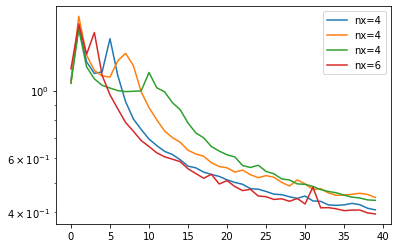

In [17]:
plt.semilogy(fit_sys_nx4_1.Loss_val[:40],label='nx=4')
plt.semilogy(fit_sys_nx4_2.Loss_val[:40],label='nx=4')
plt.semilogy(fit_sys_nx4_3.Loss_val[:40],label='nx=4')
plt.semilogy(fit_sys_nx6_1.Loss_val[:40],label='nx=6')
plt.legend()
plt.show()

In [13]:
test_nx4_1 = fit_sys_nx4_1.apply_experiment(test.flatten()).reshape_as(test)
test_nx4_2 = fit_sys_nx4_2.apply_experiment(test.flatten()).reshape_as(test)
test_nx4_3 = fit_sys_nx4_3.apply_experiment(test.flatten()).reshape_as(test)
test_nx6_1 = fit_sys_nx6_1.apply_experiment(test.flatten()).reshape_as(test)

In [18]:
print(f'\t SS  nx4  encoder     RMS = {test_nx4_1.RMS(test):4.04}, NRMS = {test_nx4_1.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS  nx4  encoder     RMS = {test_nx4_2.RMS(test):4.04}, NRMS = {test_nx4_2.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS  nx4  encoder     RMS = {test_nx4_3.RMS(test):4.04}, NRMS = {test_nx4_3.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS  nx6  encoder     RMS = {test_nx6_1.RMS(test):4.04}, NRMS = {test_nx6_1.RMS(test)/np.std(test.y):.2%}')


	 SS  nx4  encoder     RMS = 0.01607, NRMS = 7.86%
	 SS  nx4  encoder     RMS = 0.01476, NRMS = 7.22%
	 SS  nx4  encoder     RMS = 0.01562, NRMS = 7.64%
	 SS  nx6  encoder     RMS = 0.01492, NRMS = 7.30%
